In [1]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)
    
from list_prompt_family import ListPromptFamily
from prompt_registry import PROMPT_REGISTRY, ALL_PROMPTS
from wrap_registry import WRAP_REGISTRY
import numpy as np
import torch
from dotenv import load_dotenv
import os
from transformer_lens import HookedTransformer


/Users/johnwu/.pyenv/versions/3.9.1/lib/python3.9/site-packages/torch/onnx/_internal/_beartype.py:36: UserWarning: unhashable type: 'list'
  warnings.warn(f"{e}")


In [2]:
print("Available Prompts:")
for name in PROMPT_REGISTRY["list"]:
    print("-", name)

print("\nAvailable Wrap Styles:")
for name in WRAP_REGISTRY:
    print("-", name)


Available Prompts:
- print
- append
- add_all
- insert_middle
- swap_indices
- find_index

Available Wrap Styles:
- plain
- list
- interpreter
- system


In [3]:
# Example Prompt 
prompt = PROMPT_REGISTRY["list"]["append"]
case = prompt.create_case(inputs=[[1, 2, 3], 4])

print("Prompt (raw):\n", case.prompt)
print("Ground truth:", case.ground_truth)

wrap_fn = WRAP_REGISTRY["interpreter"]
wrapped_prompt = wrap_fn(prompt.prompt_fn(case.inputs), case.inputs)
print("Wrapped Prompt:\n", wrapped_prompt)

Prompt (raw):
 Append 4 to the end of this list [1, 2, 3]
Ground truth: [1, 2, 3, 4]
Wrapped Prompt:
 Pretend you are a Python interpreter.
TASK: Append 4 to the end of this list [1, 2, 3]
INPUT: [[1, 2, 3], 4]
OUTPUT:


In [4]:
# Generating multiple prompts
prompt.random_input_fn = lambda: [[1, 2, 3], np.random.randint(5, 10)]
cases = prompt.create_cases(n=3)

for c in cases:
    print("\nPrompt:")
    print(c.prompt)
    print("Expected:", c.ground_truth)



Prompt:
Append 7 to the end of this list [1, 2, 3]
Expected: [1, 2, 3, 7]

Prompt:
Append 5 to the end of this list [1, 2, 3]
Expected: [1, 2, 3, 5]

Prompt:
Append 7 to the end of this list [1, 2, 3]
Expected: [1, 2, 3, 7]


In [5]:
family = ListPromptFamily(min_val=0, max_val=5, append_max=10, list_size=3)

all_cases = family.generate_all(n=3)

for case in all_cases:
    print(f"\n{case.task_id} | wrap: {case.metadata['wrap_name']}")
    print(case.prompt)
    print("Expected:", case.ground_truth)



print-0 | wrap: plain
Print out this list of numbers: [3, 3, 3].
Expected: [3, 3, 3]

print-1 | wrap: plain
Print out this list of numbers: [1, 2, 1].
Expected: [1, 2, 1]

print-2 | wrap: plain
Print out this list of numbers: [2, 1, 0].
Expected: [2, 1, 0]

print-3 | wrap: list
Print out this list of numbers: [0, 2, 4].
Only output a list, no other information.
List: [
Expected: [0, 2, 4]

print-4 | wrap: list
Print out this list of numbers: [3, 4, 4].
Only output a list, no other information.
List: [
Expected: [3, 4, 4]

print-5 | wrap: list
Print out this list of numbers: [2, 1, 3].
Only output a list, no other information.
List: [
Expected: [2, 1, 3]

print-6 | wrap: interpreter
Pretend you are a Python interpreter.
TASK: Print out this list of numbers: [4, 0, 0].
INPUT: [[4, 0, 0]]
OUTPUT:
Expected: [4, 0, 0]

print-7 | wrap: interpreter
Pretend you are a Python interpreter.
TASK: Print out this list of numbers: [2, 2, 0].
INPUT: [[2, 2, 0]]
OUTPUT:
Expected: [2, 2, 0]

print-8 | 

In [6]:
load_dotenv()
hf_token = os.getenv("HF_TOKEN")

!huggingface-cli login --token {hf_token}

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
The token `transformerlens` has been saved to /Users/johnwu/.cache/huggingface/stored_tokens
Your token has been saved to /Users/johnwu/.cache/huggingface/token
Login successful.
Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [7]:
MODEL_NAME = "Phi-2"
torch.mps.empty_cache()
model = HookedTransformer.from_pretrained(
    MODEL_NAME,
    device="mps",                
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loaded pretrained model Phi-2 into HookedTransformer


In [9]:
family = ListPromptFamily(min_val=1, max_val=5, fill_mode="single_outlier", list_size=5)

cases = family.generate(prompt_name="find_index", wrap_name="all", n=1)

for case in cases:
    print(f"\n{case.task_id}")
    print(case.prompt)
    print("Expected:", case.ground_truth)


find_index-0
Given a zero indexed list [4, 3, 4, 4, 4], what is the index of the element 3?
Expected: 1

find_index-1
Given a one indexed list [3, 3, 3, 3, 2], what is the index of the element 2?
Only output a list, no other information.
List: [
Expected: 5

find_index-2
Pretend you are a Python interpreter.
TASK: Given a zero indexed list [3, 3, 4, 3, 3], what is the index of the element 4?
INPUT: [[3, 3, 4, 3, 3], 4, 'zero']
OUTPUT:
Expected: 2

find_index-3
<|system|> You are a helpful assistant.
<|user|> Given a zero indexed list [4, 4, 4, 4, 1], what is the index of the element 1?
<|assistant|>
Expected: 4


In [9]:
results = family.evaluate_all(model, max_tokens=20)

Evaluating prompt cases:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:  25%|██▌       | 1/4 [00:05<00:16,  5.52s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:  50%|█████     | 2/4 [00:10<00:10,  5.29s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases:  75%|███████▌  | 3/4 [00:11<00:03,  3.43s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating prompt cases: 100%|██████████| 4/4 [00:18<00:00,  4.56s/it]


Evaluation Summary: 3/4 correct (75.0%)

Success: find_index-1
Prompt:
 Given a zero indexed list [3, 3, 2, 3, 3], what is the index of the element 2?
Only output a list, no other information.
List: [
Expected: 2
Got     : <|endoftext|>Given a zero indexed list [3, 3, 2, 3, 3], what is the index of the element 2?
Only output a list, no other information.
List: [3, 3, 2, 3, 3]
Answer: 2
<|endoftext|>

Success: find_index-2
Prompt:
 Pretend you are a Python interpreter.
TASK: Given a zero indexed list [4, 4, 1, 4, 4], what is the index of the element 1?
INPUT: [[4, 4, 1, 4, 4], 1, 'zero']
OUTPUT:
Expected: 2
Got     : <|endoftext|>Pretend you are a Python interpreter.
TASK: Given a zero indexed list [4, 4, 1, 4, 4], what is the index of the element 1?
INPUT: [[4, 4, 1, 4, 4], 1, 'zero']
OUTPUT: 2
<|endoftext|>

Success: find_index-3
Prompt:
 <|system|> You are a helpful assistant.
<|user|> Given a zero indexed list [1, 1, 3, 1, 1], what is the index of the element 3?
<|assistant|>
Expec

# Targeted Failure Mode

In [ ]:
# Zero-biased case
clean_case = cases[0]
print(f"\n{clean_case}")
corrupted_case = clean_case.copy()
corrupted_case.inputs = [[4, 3, 4, 4, 4], 3, 'one']
corrupted_case.ground_truth = 2
print(f"\n{corrupted_case}")

clean_result = clean_case.run_model(model, max_tokens=20)
corrupt_result = corrupted_case.run_model(model, max_tokens=20)
print(f"\n{clean_result['output']}")
print(f"\n{corrupt_result['output']}")



PromptCase(task_id='find_index-0', inputs=[[4, 3, 4, 4, 4], 3, 'zero'], prompt_fn=<function <lambda> at 0x31ae26b80>, ground_truth=1, metadata={'prompt_name': 'find_index', 'inputs': [[4, 3, 4, 4, 4], 3, 'zero'], 'wrap_name': 'plain'}, wrap_fn=<function plain_wrap at 0x31ae26550>, generated_output='<|endoftext|>Given a zero indexed list [4, 3, 4, 4, 4], what is the index of the element 3? [4, 3, 4, 4, 4]\nAnswer: 1\n<|endoftext|>', evaluation_result={'exact_match': False, 'substring_match': True, 'output': '<|endoftext|>Given a zero indexed list [4, 3, 4, 4, 4], what is the index of the element 3? [4, 3, 4, 4, 4]\nAnswer: 1\n<|endoftext|>'})

PromptCase(task_id='find_index-0', inputs=[[4, 3, 4, 4, 4], 3, 'one'], prompt_fn=<function <lambda> at 0x31ae26b80>, ground_truth=2, metadata={'prompt_name': 'find_index', 'inputs': [[4, 3, 4, 4, 4], 3, 'zero'], 'wrap_name': 'plain'}, wrap_fn=<function plain_wrap at 0x31ae26550>, generated_output='<|endoftext|>Given a zero indexed list [4, 3, 4, 

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


<|endoftext|>Given a zero indexed list [4, 3, 4, 4, 4], what is the index of the element 3? [4, 3, 4, 4, 4]
Answer: 1
<|endoftext|>

<|endoftext|>Given a one indexed list [4, 3, 4, 4, 4], what is the index of the element 3? [4, 3, 4, 4, 4]
A: 1
<|endoftext|>


# Logit Attribution Example 

In [21]:
prompt = clean_case.prompt
tokens = model.to_tokens(prompt)
logits, cache = model.run_with_cache(tokens)

resid_final = cache["resid_post", -1][0]
unembed = model.W_U  

target_tok_id = model.to_single_token("1")  
baseline_tok_id = model.to_single_token("0")

logit_diff_direction = unembed[:, target_tok_id] - unembed[:, baseline_tok_id]
logit_contribution = resid_final @ logit_diff_direction


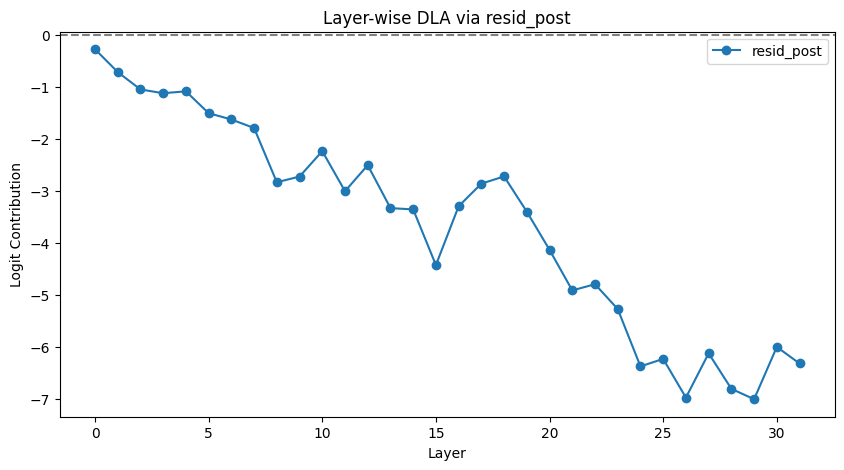

In [ ]:
import matplotlib.pyplot as plt

n_layers = model.cfg.n_layers
logit_diff_direction = (unembed[:, target_tok_id] - unembed[:, baseline_tok_id]).detach()

resid_post_contribs = []

for layer in range(n_layers):
    resid_post = cache["resid_post", layer][0] 
    contrib_post = resid_post @ logit_diff_direction
    resid_post_contribs.append(contrib_post[-1].item())

plt.figure(figsize=(10, 5))
plt.plot(resid_post_contribs, label="resid_post", marker="o")
plt.axhline(0, color="gray", linestyle="--")
plt.xlabel("Layer")
plt.ylabel("Logit Contribution")
plt.title("Layer-wise DLA via resid_post")
plt.legend()
plt.show()

# Direct Logit Attribution